In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

############################################################################################################################################################################################################################

### Load Sample Annotation for *Replicate* and *Longitudinal* Isolates

############################################################################################################################################################################################################################

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy
from collections import Counter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=2
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

#### Import Sample Annotation file for all longitudinal-pairs and replicate-pairs

In [4]:
#REPLICATE
#sample annotation for replicate pairs
sample_annotation_replicate = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/REPLICATE_fastq_path_names_and_JankyPipe_tags.csv' , sep  = ',').set_index('patient_id')

#drop unnecessary column
sample_annotation_replicate.drop('successful_run' , axis = 1 , inplace = True)

#add column to identify as Replicate Pairs
sample_annotation_replicate['isolate_type'] = ['replicate']*np.shape(sample_annotation_replicate)[0]

#LONGITUDINAL
#sample annotation for longitudinal pairs
sample_annotation_longitudinal = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/cetr_casali_walker_trauner_witney_xu_guerra_bryant_fastq_path_names_and_JankyPipe_tags.csv' , sep  = ',').set_index('patient_id')

#add column to identify as Longitudinal Pairs
sample_annotation_longitudinal['isolate_type'] = ['longitudinal']*np.shape(sample_annotation_longitudinal)[0]

In [5]:
sample_annotation_replicate.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,,
I0002918-6,0,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru4092,0,Peru4092,replicate
I0002918-6,1,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,MMMI00000000,Peru3380,0,Peru3380,replicate
I0003710-6,2,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru2905,0,Peru2905,replicate
I0003710-6,3,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,MMBH00000000,Peru4104,0,Peru4104,replicate
I0003922-7,4,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru3016,0,Peru3016,replicate


In [6]:
np.shape(sample_annotation_replicate) #number of replicate isolates

(164, 8)

In [8]:
sample_annotation_longitudinal.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,,
I0005973-8,0,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQFF00000000,Peru3062,1,Peru3062,longitudinal
I0005973-8,1,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQKH00000000,Peru3315,2,Peru3315,longitudinal
I0005229-5,2,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQAO00000000,Peru2908,1,Peru2908,longitudinal
I0005229-5,3,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQKD00000000,Peru3278,2,Peru3278,longitudinal
I0005235-2,4,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQBA00000000,Peru2921,1,Peru2921,longitudinal


In [9]:
np.shape(sample_annotation_longitudinal) #number of longitudinal isolates

(614, 8)

#### Combine to create 1 sample annotation file for all replicate and longitudinal isolate pairs

In [10]:
sample_annotation_all = sample_annotation_replicate.append(sample_annotation_longitudinal)
sample_annotation_all['patient_id'] = sample_annotation_all.index #store patient id in a column

#give each pair a unique index
unique_ids = range(0 , np.shape(sample_annotation_all)[0] / 2)
new_indices = []
for unique_id in unique_ids:
    new_indices = new_indices + [unique_id]*2
new_indices = [str(index) for index in new_indices] #convert indices to strings

sample_annotation_all['pair_index'] = new_indices
sample_annotation_all.set_index('pair_index' , inplace = True)

In [11]:
sample_annotation_all.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id
pair_index,,,,,,,,,
0,0,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru4092,0,Peru4092,replicate,I0002918-6
0,1,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,MMMI00000000,Peru3380,0,Peru3380,replicate,I0002918-6
1,2,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru2905,0,Peru2905,replicate,I0003710-6
1,3,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,MMBH00000000,Peru4104,0,Peru4104,replicate,I0003710-6
2,4,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru3016,0,Peru3016,replicate,I0003922-7


In [12]:
np.shape(sample_annotation_all)

(778, 9)

############################################################################################################################################################################################################################

### *Filter* 1 - Collect % of MTB reads for each isolate calculated from Kraken output

############################################################################################################################################################################################################################

In [14]:
#dataframe that stores the lienage calls for each isolate
MTBC_perc_DF = pd.DataFrame(index = range(0 , 2) , columns = ['pair_index' , 'population' , 'patient_id' , 'tag' , 'isolate_type' , 'MTBC_perc'])


for isolate_index in range(0, np.shape(sample_annotation_all)[0]):

    pair_index = sample_annotation_all.ix[isolate_index , :].name
    population = sample_annotation_all.ix[isolate_index , 2]
    patient_id = str(sample_annotation_all.ix[isolate_index , 8])
    tag = sample_annotation_all.ix[isolate_index , 6] #folder title in JankyPipe output directory
    isolate_type = sample_annotation_all.ix[isolate_index , 7] #replicate or longitudinal isolate
    
    #MTBC percentage
    if isolate_type == 'replicate': #look to replicate JankyPipe output directory
        MTBC_perc_txt = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output_REPLICATES/' + tag + '/kraken2/' + tag + '_MTBC_prop_from_Kraken.txt'
        
    elif isolate_type == 'longitudinal': #look to longitudinal JankyPipe output directory
        MTBC_perc_txt = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output/' + tag + '/kraken2/' + tag + '_MTBC_prop_from_Kraken.txt'
    
    #read in text file that stores the percentage of MTBC reads
    f = open(MTBC_perc_txt,'r')
    MTBC_perc_string = f.readline()

    #store pair_index , population, patient_id and sample_id in DF
    MTBC_perc_DF.ix[isolate_index , 0] = pair_index
    MTBC_perc_DF.ix[isolate_index , 1] = population
    MTBC_perc_DF.ix[isolate_index , 2] = patient_id
    MTBC_perc_DF.ix[isolate_index , 3] = tag
    MTBC_perc_DF.ix[isolate_index , 4] = isolate_type
    
    MTBC_perc_DF.ix[isolate_index , 5] = float(MTBC_perc_string)
                
#make the patient_ids the index
MTBC_perc_DF.set_index(keys = 'pair_index' , drop = True , inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [15]:
MTBC_perc_DF.head()

,population,patient_id,tag,isolate_type,MTBC_perc
pair_index,,,,,
0,LC_REP,I0002918-6,Peru4092,replicate,0.991821
0,LC_REP,I0002918-6,Peru3380,replicate,0.997687
1,LC_REP,I0003710-6,Peru2905,replicate,0.997242
1,LC_REP,I0003710-6,Peru4104,replicate,0.997562
2,LC_REP,I0003922-7,Peru3016,replicate,0.998871


In [16]:
np.shape(MTBC_perc_DF)

(778, 5)

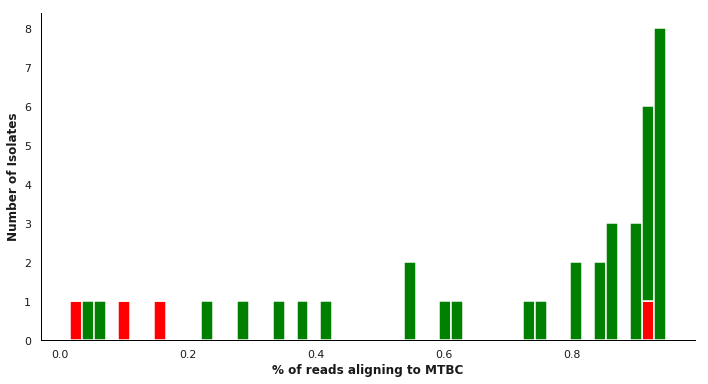

In [18]:
fig , ax = plt.subplots()

#look for contaminated isolates (w/ < 95% MTBC  reads)
contaminated_isolates = MTBC_perc_DF[MTBC_perc_DF.MTBC_perc < 0.95]

#MTBC % for replicate pairs
replicate_MTBC_perc = contaminated_isolates[contaminated_isolates.isolate_type == 'replicate'].MTBC_perc.values

#MTBC % for longitudinal pairs
longitudinal_MTBC_perc = contaminated_isolates[contaminated_isolates.isolate_type == 'longitudinal'].MTBC_perc.values

#plot replicate pairs
n , bins , patches = plt.hist( [replicate_MTBC_perc , longitudinal_MTBC_perc ] , bins = 50 , color = ['red','green'] , rwidth = 2.5 , edgecolor='white', linewidth=1.5 , stacked = True)

plt.xlabel('% of reads aligning to MTBC', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
#ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_4/Base_Call_analysis/Filtering_SNPs/All_Base_Calls_AFs_for_Base_Calls_filtered_patients.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Filter out Replicate pairs if either isolate has < 95% of reads mapping to MTBC

In [19]:
contaminated_isolates.sort_values(by = ['isolate_type' , 'population' , 'patient_id'])

,population,patient_id,tag,isolate_type,MTBC_perc
pair_index,,,,,
384,BRYANT,1020A,ERR108125,longitudinal,0.0568561
374,BRYANT,2030R,ERR171135,longitudinal,0.927181
387,BRYANT,3582J,ERR171156,longitudinal,0.0344798
378,BRYANT,4069Z,ERR171142,longitudinal,0.285775
148,CETR,2803,Peru5137,longitudinal,0.924389
152,CETR,3140,Peru4965,longitudinal,0.544248
273,GUERRA,KPS_12,ERR245847,longitudinal,0.919736
280,GUERRA,KPS_19,ERR212003,longitudinal,0.735789
294,GUERRA,KPS_33,ERR323034,longitudinal,0.23857


In [20]:
#get a list of replicate pairs in which at least 1 isolate has less than 95% MTBC reads
contaminated_replicate_pairs = list(set( contaminated_isolates.index ) )

non_contaminated_replicate_pairs = set(MTBC_perc_DF.index) - set(contaminated_replicate_pairs)
sample_annotation_non_contaminated = sample_annotation_all.loc[non_contaminated_replicate_pairs , :]

#### Isolate pairs that are filtered out because they have at least 1 isolate with < 95% of reads aligning to MTBC genomes

In [21]:
np.shape(MTBC_perc_DF.loc[contaminated_replicate_pairs , :].sort_values(by = ['isolate_type' , 'population' , 'patient_id']))

(70, 5)

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(MTBC_perc_DF.loc[contaminated_replicate_pairs , :].sort_values(by = ['isolate_type' , 'population' , 'patient_id']))

,population,patient_id,tag,isolate_type,MTBC_perc
pair_index,,,,,
384,BRYANT,1020A,ERR108126,longitudinal,0.996957
384,BRYANT,1020A,ERR108125,longitudinal,0.0568561
374,BRYANT,2030R,ERR171134,longitudinal,0.997825
374,BRYANT,2030R,ERR171135,longitudinal,0.927181
387,BRYANT,3582J,ERR171156,longitudinal,0.0344798
387,BRYANT,3582J,ERR171157,longitudinal,0.994995
378,BRYANT,4069Z,ERR171142,longitudinal,0.285775
378,BRYANT,4069Z,ERR171143,longitudinal,0.973172
148,CETR,2803,Peru4928,longitudinal,0.996576


#### Count the number of longitudinal Isolates dropped because they have at least 1 isolate with < 95% of reads aligning to MTBC genomes (divide count by 2 to get number of pairs dropped)

In [23]:
Counter( list( MTBC_perc_DF.loc[contaminated_replicate_pairs , :].sort_values(by = ['isolate_type' , 'population' , 'patient_id']).population ) )

Counter({'BRYANT': 8,
         'CETR': 4,
         'CP_REP': 6,
         'GUERRA': 22,
         'TRAUNER': 2,
         'WITNEY': 24,
         'XU': 4})

We drop 3 replicate pairs and 32 longitudinal pairs

In [24]:
sample_annotation_non_contaminated.head(n=6)

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id
pair_index,,,,,,,,,
344,524,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR18...,GUERRA,ERR181827,NaN,1,ERR181827,longitudinal,KPS_83
344,525,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR21...,GUERRA,ERR212156,NaN,2,ERR212156,longitudinal,KPS_83
345,526,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR47...,GUERRA,ERR473307,NaN,1,ERR473307,longitudinal,KPS_84
345,527,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR73...,GUERRA,ERR736847,NaN,2,ERR736847,longitudinal,KPS_84
346,528,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108127,300239.0,1,ERR108127,longitudinal,2014W
346,529,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108128,301725.0,2,ERR108128,longitudinal,2014W


In [25]:
#re-place sample annotation DF with sample annotation DF containing replicate pairs in which BOTH isolates had >= 95% of reads mapping to MTB
sample_annotation_all = sample_annotation_non_contaminated

In [26]:
np.shape(sample_annotation_all)

(708, 9)

############################################################################################################################################################################################################################

### *Filter* 1.5 - Filter out replicate pair where coverage was extremely low in 1 isolate

############################################################################################################################################################################################################################

After filtering out isolates by read classification, filter out a replicate pair that had 1 isolate in which most reads (99%) reads classified by MTBC but had extremely low coverage (~1x). We were not able to call lineage SNPs from this isolate since we require at least 25 reads at a given locus for every SNP call.

In [27]:
sample_annotation_all[sample_annotation_all.tag == '02-R1447']

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id
pair_index,,,,,,,,,
69,139,/n/data1/hms/dbmi/farhat/fastq_db/pools/02-R14...,CP_REP,NaN,02-R1447,0,02-R1447,replicate,replicate_pair_65


We drop 1 replicate pair

In [28]:
sample_annotation_all.drop('69' , inplace = True)

In [29]:
np.shape(sample_annotation_all)

(706, 9)

############################################################################################################################################################################################################################

### *Filter* 2 - Filter out patients where isolates show signs of contamination by F2 mixed measure (Wyllie et al. 2018)

############################################################################################################################################################################################################################

### *Functions* that calculate the F2 mixed measure

In [30]:
def calculate_minor_allele_fraction_per_SNP_set(lineage_SNPs_from_sample_DF):

    #get a list of all lineages (i.e. branches) that we have SNP information for
    all_lineages = list( set( list(lineage_SNPs_from_sample_DF.lineage) ) )

    #create a series that will store the minor allele fraction (p) for each lineage set
    minor_allele_fraction_per_SNP_set = pd.Series(index = all_lineages)

    for lineage in minor_allele_fraction_per_SNP_set.index:

        #subset to lineage-defining SNPs
        specific_lineage_SNPs_depths = lineage_SNPs_from_sample_DF[lineage_SNPs_from_sample_DF.lineage == lineage]

        #calculate the Total Depth across all SNP sites for this SNP set
        D = np.sum(specific_lineage_SNPs_depths.depth)

        #calculate the Total Minor Depth
        M = np.sum(specific_lineage_SNPs_depths.minor_depth)

        #calculate the minor allele fraction 
        p = float(M) / float(D)

        #store p for this SNP set in series
        minor_allele_fraction_per_SNP_set[lineage] = p

    #sort values in descending order
    minor_allele_fraction_per_SNP_set.sort_values(ascending = False , inplace = True)
    
    return minor_allele_fraction_per_SNP_set

In [31]:
def calculate_F2(sorted_minor_allele_fraction_per_SNP_set):

    #calculate F2 - get top 2 lineages with the highest minor allele frequencies
    F2_lineages = list( sorted_minor_allele_fraction_per_SNP_set[0:2].index )

    #subset to SNPs that belong to either SNP set in F2 lineages
    F2_lineage_filter = [lineage in F2_lineages for lineage in list(lineage_SNP_depths_from_sample_DF.lineage)]
    F2_lineage_SNP_depths_DF = lineage_SNP_depths_from_sample_DF[F2_lineage_filter]

    #calculate the Total Depth across all SNP sites for this SNPs belonging to F2 SNP sets
    D2 = np.sum(F2_lineage_SNP_depths_DF.depth)

    #calculate the Total Minor Depth
    M2 = np.sum(F2_lineage_SNP_depths_DF.minor_depth)

    #calculate the minor allele fraction 
    p2 = float(M2) / float(D2)
    
    return p2

In [32]:
#use sample annotation and iterate through all samples
contamination_metric_DF = sample_annotation_all.copy()

#directory where VCF file for sequenced isolated is stored & filename
parent_output_dir_replicate = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output_REPLICATES/' #where output for replicate isolates is stored
parent_output_dir_longitudinal = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output/' #where output for longitudinal isolates is stored

#thresholds from Wyllie et. al.
F2_threshold = 0.047

In [34]:
F2_calculations = []

for sample_row_i in range(0 , len(contamination_metric_DF)):
    
    tag = contamination_metric_DF.iloc[sample_row_i , 6]
    isolate_type = contamination_metric_DF.iloc[sample_row_i , 7]
    
    #load pickled depths for lineage SNPs DataFrame
    if isolate_type == 'replicate':
        lineage_SNP_depths_from_sample_DF = pd.read_pickle(parent_output_dir_replicate + tag + '/' + tag + '_lineage_defining_SNP_depths.pkl')
        
    elif isolate_type == 'longitudinal':
        lineage_SNP_depths_from_sample_DF = pd.read_pickle(parent_output_dir_longitudinal + tag + '/' + tag + '_lineage_defining_SNP_depths.pkl')
    
    #calculate minor allele frequency estimates for all SNP sets & sort in descending order
    sorted_minor_allele_fraction_per_SNP_set = calculate_minor_allele_fraction_per_SNP_set(lineage_SNP_depths_from_sample_DF)

    #calculate F2
    F2 = calculate_F2(sorted_minor_allele_fraction_per_SNP_set)
    
    #store in list to append to DF later
    F2_calculations.append(F2)
    
contamination_metric_DF['F2'] = F2_calculations

In [35]:
contamination_metric_DF.sort_values(by = ['isolate_type','patient_id'] , inplace = True)

In [36]:
contamination_metric_DF.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,F2
pair_index,,,,,,,,,,
222,280,/n/data1/hms/dbmi/farhat/fastq_db/witney/ERR17...,WITNEY,ERR1750873,SAMEA23740168,1,ERR1750873,longitudinal,1,0.007540
222,281,/n/data1/hms/dbmi/farhat/fastq_db/witney/ERR17...,WITNEY,ERR1750874,SAMEA23740918,2,ERR1750874,longitudinal,1,0.008892
231,298,/n/data1/hms/dbmi/farhat/fastq_db/witney/ERR17...,WITNEY,ERR1750891,SAMEA23753668,1,ERR1750891,longitudinal,10,0.012434
231,299,/n/data1/hms/dbmi/farhat/fastq_db/witney/ERR17...,WITNEY,ERR1750892,SAMEA23754418,2,ERR1750892,longitudinal,10,0.014761
232,300,/n/data1/hms/dbmi/farhat/fastq_db/witney/ERR17...,WITNEY,ERR1750893,SAMEA23755168,1,ERR1750893,longitudinal,11,0.007892


In [37]:
contamination_metric_DF.tail()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,F2
pair_index,,,,,,,,,,
78,157,/n/data1/hms/dbmi/farhat/fastq_db/pools/03-R03...,CP_REP,NaN,03-R0324,0,03-R0324,replicate,replicate_pair_74,0.006133
13,26,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMOZ00000000,Peru4671,0,Peru4671,replicate,replicate_pair_8,0.014376
13,27,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R01...,CP_REP,NaN,01-R0185,0,01-R0185,replicate,replicate_pair_8,0.004313
14,28,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMUK00000000,Peru4519,0,Peru4519,replicate,replicate_pair_9,0.004961
14,29,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R02...,CP_REP,NaN,01-R0238,0,01-R0238,replicate,replicate_pair_9,0.004541


In [38]:
np.shape( contamination_metric_DF[contamination_metric_DF.isolate_type == 'replicate'] )

(156, 10)

In [39]:
np.shape( contamination_metric_DF[contamination_metric_DF.isolate_type == 'longitudinal'] )

(550, 10)

#### Plot F2 Measure for 156 replicate isolates and 550 serial isolates

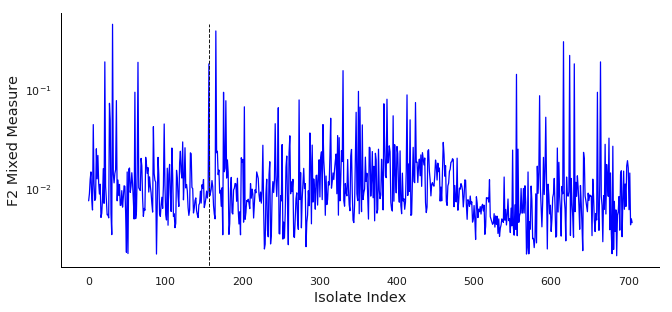

In [41]:
fig , ax = plt.subplots()

sample_indices = range(0 , np.shape(contamination_metric_DF)[0])
number_replicate_pairs = np.shape( contamination_metric_DF[contamination_metric_DF.isolate_type == 'replicate'] )[0]

plt.plot(sample_indices , contamination_metric_DF.F2 , color = 'blue' , linewidth = 1.25 , label = 'F2')
plt.plot([number_replicate_pairs , number_replicate_pairs] , [0 , max( contamination_metric_DF.F2 )] , color = 'k' , linewidth = 1.0 , linestyle = '--')

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## ax.legend(loc='upper left')
ax.set_yscale("log", nonposy='clip')

ax.tick_params(labelcolor = 'k')

ax.set_xlabel('Isolate Index' , color = 'k')
ax.set_ylabel('F2 Mixed Measure' , color = 'k')

fig = plt.gcf()
fig.set_size_inches(9.5, 4.5)
fig.tight_layout()

#output for Adobe Illustrator
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Mixed_Lineage_SNP_analysis/F2_across_all_isolates.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()
##################################################################

#### Distribution of the F2 Measure across all isolates

Top contaminated isolates according to the F2 measure

In [42]:
contamination_metric_DF.sort_values(by='F2' , ascending = False).head(n=30)

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,F2
pair_index,,,,,,,,,,
116,69,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMUZ00000000,Peru5028,2,Peru5028,longitudinal,1671,0.456355
362,561,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171167,402713.0,2,ERR171167,longitudinal,3162L,0.390782
36,72,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMYB00000000,Peru4947,0,Peru4947,replicate,replicate_pair_31,0.304399
40,80,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMXV00000000,Peru4953,0,Peru4953,replicate,replicate_pair_35,0.221328
111,59,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMVC00000000,Peru5025,2,Peru5025,longitudinal,1646,0.190423
60,120,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMVC00000000,Peru5025,0,Peru5025,replicate,replicate_pair_55,0.190423
346,528,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108127,300239.0,1,ERR108127,longitudinal,2014W,0.188548
44,88,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMXH00000000,Peru4967,0,Peru4967,replicate,replicate_pair_39,0.181929
153,142,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMXH00000000,Peru4967,1,Peru4967,longitudinal,3145,0.181929


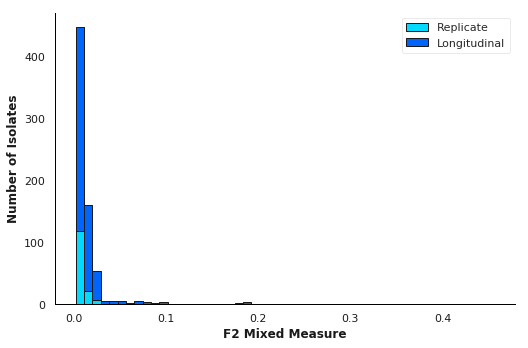

In [47]:
fig , ax = plt.subplots()

#get F2 metric values for all replicate isolates
F2_replicate_values = contamination_metric_DF[contamination_metric_DF.isolate_type == 'replicate'].F2.values

#get F2 metric values for all longitudinal isolates
F2_longitudinal_values = contamination_metric_DF[contamination_metric_DF.isolate_type == 'longitudinal'].F2.values

#plot replicate & longitudinal pairs
n , bins , patches = plt.hist( [F2_replicate_values , F2_longitudinal_values] , bins = 50 , color = ['xkcd:neon blue' , 'xkcd:bright blue'] , rwidth = 1.0 , edgecolor='k', linewidth=1.0 , stacked = True , label = ['Replicate','Longitudinal'])

plt.xlabel('F2 Mixed Measure', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper right')
ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Mixed_Lineage_SNP_analysis/F2_distribution_for_all_isolates.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

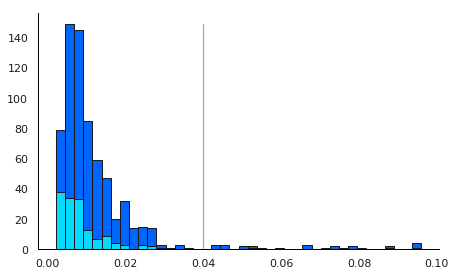

In [48]:
fig , ax = plt.subplots()

#get F2 metric values for all replicate isolates
F2_replicate_values = contamination_metric_DF[contamination_metric_DF.isolate_type == 'replicate'].F2.values

#get F2 metric values for all longitudinal isolates
F2_longitudinal_values = contamination_metric_DF[contamination_metric_DF.isolate_type == 'longitudinal'].F2.values

#plot replicate pairs
n , bins , patches = plt.hist( [F2_replicate_values[F2_replicate_values < 0.1] , F2_longitudinal_values[F2_longitudinal_values < 0.1]] , bins = 40 , color = ['xkcd:neon blue' , 'xkcd:bright blue'] , rwidth = 1.0 , edgecolor='k', linewidth=1.0 , stacked = True)

#plot threshold (based off looking at the distribution)
F2_threshold = 0.04
plt.plot([F2_threshold , F2_threshold] , [0 , np.max(n)] , color = '0.65' , linewidth = 1.25 , linestyle = '-')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(6.5, 4.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Mixed_Lineage_SNP_analysis/F2_distribution_across_for_isolates_ZOOMED.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Contaminated samples by F2 measure

In [49]:
contamination_metric_DF[contamination_metric_DF.F2 > F2_threshold].sort_values(by = ['isolate_type' , 'population' , 'patient_id'])

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,F2
pair_index,,,,,,,,,,
386,608,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171154,1500283.0,2,ERR171154,longitudinal,1117N,0.044335
346,528,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108127,300239.0,1,ERR108127,longitudinal,2014W,0.188548
362,561,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171167,402713.0,2,ERR171167,longitudinal,3162L,0.390782
376,588,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171138,200541.0,1,ERR171138,longitudinal,4098U,0.067026
111,59,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMVC00000000,Peru5025,2,Peru5025,longitudinal,1646,0.190423
114,65,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMVB00000000,Peru5026,2,Peru5026,longitudinal,1667,0.072711
115,66,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMVA00000000,Peru5027,1,Peru5027,longitudinal,1669,0.049305
116,69,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMUZ00000000,Peru5028,2,Peru5028,longitudinal,1671,0.456355
119,74,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMTR00000000,Peru4538,1,Peru4538,longitudinal,1674,0.077446


In [50]:
np.shape(contamination_metric_DF[contamination_metric_DF.F2 > F2_threshold])

(39, 10)

39 isolates were contaminated according to the F2 metric (all belonging to different isolate pairs)

#### Get list of contaminated isolate pairs

A contaminated pair is one in which at least 1 isolate does not pass F2 thresholds

In [51]:
contaminated_isolate_pairs =  set( contamination_metric_DF[contamination_metric_DF.F2 > F2_threshold].index )

In [52]:
len(contaminated_isolate_pairs)

39

#### Number of pairs in which neither isolate was flagged as contaminated

A non-contaminated pair is one in which both isolates pass the F2 threshold

In [53]:
non_contaminated_isolate_pairs = list(set(sample_annotation_all.index) - set(contaminated_isolate_pairs))

In [54]:
len(non_contaminated_isolate_pairs)

314

### *Subset* sample annotation by isolate-pairs that passed *Kraken2 filter* but showed signs of contamination by *F2 measure*

In [55]:
sample_annotation_contaminated = sample_annotation_all.loc[contaminated_isolate_pairs , :]

In [56]:
np.shape(sample_annotation_contaminated)

(78, 9)

Count the number of **Replicate** Isolates dropped in which at least 1 isolate (per pair) was contaminated by F2 (divide count by 2 to get number of pairs dropped)

In [57]:
sample_annotation_contaminated[sample_annotation_contaminated.isolate_type == 'replicate'].sort_values('patient_id').head(n=6)

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id
pair_index,,,,,,,,,
3,6,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,MMAF00000000,Peru4133,0,Peru4133,replicate,I0003905-2
3,7,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,LC_REP,NaN,Peru3343,0,Peru3343,replicate,I0003905-2
22,44,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMOY00000000,Peru4672,0,Peru4672,replicate,replicate_pair_17
22,45,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R07...,CP_REP,NaN,01-R0737,0,01-R0737,replicate,replicate_pair_17
25,50,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMHB00000000,Peru4714,0,Peru4714,replicate,replicate_pair_20
25,51,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R08...,CP_REP,NaN,01-R0880,0,01-R0880,replicate,replicate_pair_20


In [58]:
Counter( sample_annotation_contaminated[sample_annotation_contaminated.isolate_type == 'replicate'].sort_values('patient_id').population )

Counter({'CP_REP': 14, 'LC_REP': 2})

Count the number of **Longitudinal** Isolates dropped in which at least 1 isolate (per pair) was contaminated by F2 (divide count by 2 to get number of pairs dropped)

In [59]:
sample_annotation_contaminated[sample_annotation_contaminated.isolate_type == 'longitudinal'].sort_values('patient_id').head(n=6)

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id
pair_index,,,,,,,,,
386,608,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171154,1500283.0,2,ERR171154,longitudinal,1117N
386,609,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171155,1500034.0,1,ERR171155,longitudinal,1117N
111,59,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMVC00000000,Peru5025,2,Peru5025,longitudinal,1646
111,58,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMUG00000000,Peru4523,1,Peru4523,longitudinal,1646
114,65,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMVB00000000,Peru5026,2,Peru5026,longitudinal,1667
114,64,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMTW00000000,Peru4533,1,Peru4533,longitudinal,1667


In [60]:
Counter( sample_annotation_contaminated[sample_annotation_contaminated.isolate_type == 'longitudinal'].sort_values('patient_id').population )

Counter({'BRYANT': 8, 'CETR': 24, 'GUERRA': 26, 'WITNEY': 4})

Get list of patients that were contaminated by F2 measure

In [61]:
print list( set( sample_annotation_contaminated[sample_annotation_contaminated.isolate_type == 'longitudinal'].patient_id ) )

['3162L', 'I0004290-8', '2459', 'KPS_45', 'KPS_40', 'KPS_43', 'KPS_42', '3145', 'KPS_83', 'KPS_8', '2014W', '2', '1674', '1671', 'KPS_32', 'KPS_78', '1117N', '3641', '21', '1646', 'I0001485-7', 'I0002074-8', '3443', 'KPS_65', 'KPS_63', 'KPS_69', '1669', '1667', 'KPS_20', '4098U', 'KPS_25']


############################################################################################################################################################################################################################

### *Subset* sample annotation by isolate-pairs that passed *Kraken2 filter* and showed *no sign of contamination by F2 metrics*


############################################################################################################################################################################################################################

In [62]:
sample_annotation_non_contaminated = sample_annotation_all.loc[non_contaminated_isolate_pairs , :]

In [63]:
sample_annotation_non_contaminated.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id
pair_index,,,,,,,,,
216,268,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352324,SAMEA3920989,1,ERR1352324,longitudinal,P07
216,269,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352328,SAMEA3920993,2,ERR1352328,longitudinal,P07
217,270,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352329,SAMEA3920994,1,ERR1352329,longitudinal,P08
217,271,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352333,SAMEA3920998,2,ERR1352333,longitudinal,P08
66,132,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMOI00000000,Peru4688,0,Peru4688,replicate,replicate_pair_61


In [64]:
#re-place sample annotation DF with sample annotation DF containing replicate pairs in which neither isolate showed signs of contamination
sample_annotation_all = sample_annotation_non_contaminated

In [65]:
np.shape(sample_annotation_all)

(628, 9)

#### Split up sample annotation into Replicate pairs and Longitudinal pairs for downstream analysis

In [66]:
sample_annotation_replicate = sample_annotation_all[sample_annotation_all.isolate_type == 'replicate']

print np.shape(sample_annotation_replicate)[0] / 2 #number of replicate pairs left after filtering

70


In [67]:
sample_annotation_longitudinal = sample_annotation_all[sample_annotation_all.isolate_type == 'longitudinal']

print np.shape(sample_annotation_longitudinal)[0] / 2 #number of longitudinal pairs left after filtering

244


Save filtered sample annotation as CSVs

In [68]:
#replicate pairs
sample_annotation_replicate.set_index('patient_id' , drop = True , inplace = True) #set patient id as index
sample_annotation_replicate = sample_annotation_replicate.loc[: , ['fastq_files' , 'population' , 'run_ID' , 'sample_ID' , 'sample_order' , 'tag' , 'isolate_type']] #re-order columns
sample_annotation_replicate.to_csv( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Replicate_fastq_path_names_and_JankyPipe_tags_filtered_with_Kraken_and_F2.csv' , sep = ',') #save replicate pairs that passed filtering

#serial pairs
sample_annotation_longitudinal.set_index('patient_id' , drop = True , inplace = True) #set patient id as index
sample_annotation_longitudinal = sample_annotation_longitudinal.loc[: , ['fastq_files' , 'population' , 'run_ID' , 'sample_ID' , 'sample_order' , 'tag' , 'isolate_type']] #re-order columns
sample_annotation_longitudinal.to_csv( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_with_Kraken_and_F2.csv' , sep = ',') #save longitudinal pairs that passed filtering